<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>
<hr/>
<font color="#800080" size=5>
Assignment 1 : Deep Autoregressive Models
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2025
<br>
</font>
<font face="Times New Roman" size=4>
</font>
<hr>
<font color='red'  size=4>
<br>
</font>
<font face="Times New Roman" size=4 align=center>
Feel free to ask your questions in Telegram : @imoonamm
</font>
<br>
<hr>
</div></font>

**You should only change the blank sections, marked with TODO**

Pay attention to docstrings, as they may drastically help with your implementation.

You are advised to read all related papers and material, to help you better understand the design of each model.

# Question 1: WaveNet : A generative model for raw audio

WaveNet is a general purpose technology that has allowed us to unlock a range of new applications, from improving video calls on even the weakest connections to helping people regain their original voice after losing the ability to speak.

![Local GIF](https://github.com/ParsaGhezelbash/Deep-Generative-Models/blob/main/HW/HW%201/unnamed.gif?raw=1)

WaveNet models raw audio waveforms autoregressively:
$
p(x_{1:T}) = \prod_{t=1}^T p(x_t \mid x_{<t})
$
\
Instead of predicting spectrograms or using a vocoder, WaveNet predicts the next audio sample directly (often after µ-law companding and 8-bit/256-way quantization). This yields very natural sounding speech and music because the network learns the waveform structure end-to-end.

## 2. Core

### 2.1 Causal convolutions
A causal 1D convolution ensures predictions at time \(t\) don't depend on future samples:
- Achieved by padding only on the left (past).
- In practice, use `padding = dilation * (kernel_size - 1)` and then trim the rightmost elements (or use `Chomp1d` cropping).

### 2.2 Dilated convolutions
Dilations `[1, 2, 4, 8, ...]` in stacked layers let the receptive field grow exponentially with depth while keeping the number of parameters manageable. A stack of several cycles of dilations covers long temporal context (hundreds to thousands of samples).

### 2.3 Gated activation units
Each residual block uses a gated unit:
$
\text{z} = \tanh(W_f * x) \odot \sigma(W_g * x)
$
where `*` is dilated causal conv, `W_f` and `W_g` are convolution filters. The output splits to (1) residual connection and (2) skip connection that is added to final output.

### 2.4 Residual & skip connections
- Residual: `x_{l+1} = x_l + \text{residual\_out}` to ease training.
- Skip: every block outputs a skip tensor; all skip outputs are summed, then passed through post-processing (ReLU, Conv, softmax) to produce the final distribution over quantized samples.

### 2.5 Output quantization / softmax
Audio samples are often µ-law quantized to 256 values; WaveNet predicts a categorical distribution (`softmax(256)`) over those values for each time step. Continuous outputs are also possible (mixture of logistics / Gaussians) but discrete softmax is standard in the original paper.

### 2.6 Conditioning
- **Global conditioning**: a per-utterance vector (e.g., speaker id embedding) is added to layer activations.
- **Local conditioning**: low-rate features (e.g., mel spectrogram) are upsampled (transposed conv / nearest) and added at each time step.

---

## 3. Training & sampling

### Training
- Teacher forcing: at training time the network receives true previous samples and learns to predict the next sample with cross-entropy loss (if quantized).
- Batch size and optimization: use Adam, gradient clipping recommended for stability.
- Preprocess: µ-law companding + 256-level quantization is common.

### Sampling (inference)
- Autoregressive generation: sample one sample at a time and feed it back.
- Slow by default — many acceleration techniques exist (distillation → Parallel Wavenet, caching convolutions, WaveRNN, etc.).



**Reference:** [WaveNet: A Generative Model for Raw Audio* (van den Oord et al., DeepMind, 2016)](https://arxiv.org/abs/1609.03499)


In [105]:
!pip install torchaudio
# !pip install git+git://github.com/pytorch/audio
import torchaudio
import os

In [106]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import ModuleList
from IPython.display import Audio
from torch.autograd import Variable
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


### at first you must convert input into One Hot vector

5 Points


In [107]:
class OneHot(nn.Module):
    def __init__(self, MU):
        super(OneHot, self).__init__()
        self.MU = MU

    def forward(self, x):
        # Ensure long dtype for indexing
        x_long = x.long()
        # torch.nn.functional.one_hot already returns the desired tensor
        one_hot = torch.nn.functional.one_hot(x_long, num_classes=self.MU)
        return one_hot.float()

    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.MU)

Before diving into the WaveNet model itself, it’s important to understand what kind of **data** we are modeling — **raw audio waveforms**.  
Neural networks can only process numbers, so we need to represent sound in a numerical form that captures its essential structure and variation.

---

## 1. Sampling Rate and Bit Depth

### Sound as a Signal
Sound in the real world is a **continuous analog waveform** — a pressure signal that varies smoothly over time.  
To process it digitally, we **sample** it: we take discrete measurements of the amplitude at equally spaced time intervals.

This process converts a continuous signal into a **time series of numbers**:
$
x = [x_1, x_2, \dots, x_T]
$
where each \(x_t\) represents the air pressure (or voltage) at time step \(t\).

---

### Sampling Rate
The **sampling rate** defines **how many times per second** we measure the amplitude of the signal.  
Typical values:
- CD quality audio: 44,100 Hz (samples per second)
- Speech datasets: 16,000 Hz or 22,050 Hz

A higher sampling rate means more detail, but also more data to process.  
WaveNet typically models 16 kHz or 22 kHz audio for speech generation tasks.

---

### Bit Depth
Each recorded sample must be represented by a finite number of bits.  
The **bit depth** determines the range and precision of these values:
- 8-bit → 256 possible levels  
- 16-bit → 65,536 levels  
- 24-bit → 16,777,216 levels  

The bit depth affects the **signal-to-noise ratio (SNR)** — higher bit depth means less quantization noise and a larger dynamic range:
$
\text{SNR} \approx 6.02 \times \text{bit depth} + 1.76\ \text{dB}
$

For example:
- 8-bit ≈ 49.9 dB SNR  
- 16-bit ≈ 98 dB SNR

---

## 2. From Audio to Time Series

After digitization, the audio signal becomes a **sequence of numbers over time**, also known as a **time series**.  
Each point depends on previous ones — this temporal dependency is what WaveNet models autoregressively:
$
p(x_{1:T}) = \prod_{t=1}^{T} p(x_t \mid x_{<t})
$

However, raw 16-bit audio contains **too many values** (65,536 possible amplitudes).  
Predicting the exact next value among that huge range is extremely hard for a neural network.

To simplify, we reduce this dynamic range to a smaller set — typically **256 levels** — using a technique called **µ-law companding**.

---

## 3. µ-law Quantization (Companding Transformation)

### Motivation
Human hearing follows the **Weber–Fechner law** — our perception of changes in loudness is **logarithmic**, not linear.  
That means we are more sensitive to small amplitude changes in quiet sounds than in loud ones.

µ-law companding exploits this property by **compressing the amplitude range logarithmically** —  
it allocates more resolution to small signals (quiet sounds) and less to large ones.

---

### µ-law Formula

$
f(x) = \text{sign}(x) \cdot \frac{\ln(1 + \mu |x|)}{\ln(1 + \mu)}, \quad -1 \le x \le 1
$

where:
- \(x\) = input waveform (normalized to [-1, 1])  
- \(\mu\) = companding constant (usually 255 for 8-bit quantization)

After applying µ-law, we map the range \([-1, 1]\) to discrete integer values \([0, 255]\).

---


## Defining Wavenet

20 Points

The following figure describes the overall architecture of WaveNet. Note that Transformers were non-existent in 2016!

![Wavenet Arch](https://github.com/ParsaGhezelbash/Deep-Generative-Models/blob/main/HW/HW%201/WaveNet.png?raw=1)

In [108]:
class Wavenet(nn.Module):
  def __init__(self,dilation_depth, n_blocks, n_dil_channels, n_residual_channels,n_skip_channels, n_category, kernel_size):
    super(Wavenet,self).__init__()
    self.dilation_depth = dilation_depth
    self.n_blocks = n_blocks
    self.n_dil_channels = n_dil_channels
    self.n_residual_channels = n_residual_channels
    self.n_skip_channels = n_skip_channels
    self.n_category = n_category
    self.kernel_size = kernel_size
    self.One_hot = OneHot(n_category)

    ###Building the model###

    ##creating first channels##
    self.input_conv = nn.Conv1d(n_category, n_residual_channels, kernel_size=1)

    ###Creating wavenet blocks stacks###
    # Build dilation rates: [1, 2, 4, 8, ..., 2^(dilation_depth-1)] repeated n_blocks times
    self.dilations = []
    for block in range(n_blocks):
      for layer in range(dilation_depth):
        self.dilations.append(2 ** layer)

    # Create WaveNet blocks
    self.blocks = nn.ModuleList()
    for i, dilation in enumerate(self.dilations):
      # Filter and gate convolutions - set padding to 0, will handle padding manually in forward
      filter_conv = nn.Conv1d(n_residual_channels, n_dil_channels,
                              kernel_size=kernel_size,
                              dilation=dilation,
                              padding=0) # Changed padding to 0
      gate_conv = nn.Conv1d(n_residual_channels, n_dil_channels,
                            kernel_size=kernel_size,
                            dilation=dilation,
                            padding=0) # Changed padding to 0

      # Residual connection: 1x1 conv from dilated channels to residual channels
      residual_conv = nn.Conv1d(n_dil_channels, n_residual_channels, kernel_size=1)

      # Skip connection: 1x1 conv from dilated channels to skip channels
      skip_conv = nn.Conv1d(n_dil_channels, n_skip_channels, kernel_size=1)

      self.blocks.append(nn.ModuleDict({
        'filter': filter_conv,
        'gate': gate_conv,
        'residual': residual_conv,
        'skip': skip_conv
      }))

    ##post convoluions
    # Post-processing: ReLU -> conv -> ReLU -> output conv
    self.post_conv1 = nn.Conv1d(n_skip_channels, n_skip_channels, kernel_size=1)
    self.post_conv2 = nn.Conv1d(n_skip_channels, n_category, kernel_size=1)

  def forward(self, x):
    # x shape: [batch_size, seq_len] with integer values in [0, n_category-1]

    # Convert to one-hot: [batch_size, seq_len] -> [batch_size, seq_len, n_category]
    x_onehot = self.One_hot(x)  # [batch_size, seq_len, n_category]

    # Transpose for conv1d: [batch_size, n_category, seq_len]
    x_onehot = x_onehot.transpose(1, 2)

    # Input convolution
    x = self.input_conv(x_onehot)  # [batch_size, n_residual_channels, seq_len]

    # Initialize skip connections accumulator
    skip_outputs = []

    # Pass through all WaveNet blocks
    for i, block in enumerate(self.blocks):
      # Store input for residual connection
      residual_input = x

      dilation = self.dilations[i] # Get current dilation rate
      pad_amount = dilation * (self.kernel_size - 1)

      # Manually pad input for causal convolution
      # Pad on the left side: (padding_left, padding_right)
      x_padded = F.pad(x, (pad_amount, 0))

      # Dilated causal convolutions
      filter_out = block['filter'](x_padded)  # Output length will be original seq_len
      gate_out = block['gate'](x_padded)      # Output length will be original seq_len

      # Gated activation: tanh(filter) * sigmoid(gate)
      gated = torch.tanh(filter_out) * torch.sigmoid(gate_out)

      # Residual connection: add to input
      residual = block['residual'](gated)  # [batch_size, n_residual_channels, seq_len]
      x = residual_input + residual

      # Skip connection: collect for later
      skip = block['skip'](gated)  # [batch_size, n_skip_channels, seq_len]
      skip_outputs.append(skip)

    # Sum all skip connections
    skip_sum = sum(skip_outputs)  # [batch_size, n_skip_channels, seq_len]

    # Post-processing
    out = torch.relu(skip_sum)
    out = self.post_conv1(out)
    out = torch.relu(out)
    out = self.post_conv2(out)  # [batch_size, n_category, seq_len]

    # Transpose back: [batch_size, seq_len, n_category]
    out = out.transpose(1, 2)

    # Return logits: [batch_size, seq_len, n_category]
    return out

  ###Function to generate samples###
  def generate(self, input, num_samples=100):
      # input shape: [batch_size, seq_len] or [seq_len] with integer values
      self.eval()
      gen_list = []

      with torch.no_grad():
        # Ensure input is 2D and on correct device
        if input.dim() == 1:
          input = input.unsqueeze(0)
        if isinstance(input, torch.Tensor):
          input = input.to(next(self.parameters()).device)
        else:
          input = torch.tensor(input, device=next(self.parameters()).device)

        # Start with input sequence
        current_seq = input.clone()

        for _ in range(num_samples):
          # Forward pass to get logits for next sample
          logits = self.forward(current_seq)  # [batch_size, seq_len, n_category]

          # Get logits for the last time step
          next_logits = logits[:, -1, :]  # [batch_size, n_category]

          # Sample from categorical distribution
          probs = torch.softmax(next_logits, dim=-1)
          next_sample = torch.multinomial(probs, 1)  # [batch_size, 1]

          # Append to generation list
          if next_sample.size(0) == 1:
            gen_list.append(next_sample.item())
          else:
            gen_list.append(next_sample.squeeze().cpu().numpy().tolist())

          # Append to current sequence
          current_seq = torch.cat([current_seq, next_sample], dim=1)

      return gen_list

Quantization of 16 bit audio

5 Points

In [109]:
def mulaw_quantize(x, qc):
    # µ-law companding constant
    mu = qc - 1

    # Ensure input is in [-1, 1] range
    x = np.clip(x, -1.0, 1.0)

    # Apply µ-law companding: sign(x) * ln(1 + μ|x|) / ln(1 + μ)
    sign_x = np.sign(x)
    abs_x = np.abs(x)
    x_mu = sign_x * np.log(1 + mu * abs_x) / np.log(1 + mu)

    # Scale from [-1, 1] to [0, qc-1] and quantize
    x_mu = (x_mu + 1) / 2 * (qc - 1)
    x_mu = np.round(x_mu).astype(np.int32)
    x_mu = np.clip(x_mu, 0, qc - 1)

    return x_mu

Inverse quantization

5 Points

In [110]:
def inv_mulaw_quantize(x_mu, quantization_channels=256, device = device):
    # Handle both numpy arrays and torch tensors
    is_torch = False
    if isinstance(x_mu, torch.Tensor):
        is_torch = True
        x_mu_np = x_mu.detach().cpu().numpy()
    else:
        x_mu_np = np.asarray(x_mu)

    # µ-law companding constant
    mu = quantization_channels - 1

    # Ensure input is in valid range
    x_mu_np = np.clip(x_mu_np, 0, quantization_channels - 1)

    # Convert from [0, qc-1] back to [-1, 1] range
    y = (x_mu_np / (quantization_channels - 1)) * 2.0 - 1.0

    # Apply inverse µ-law: x = sign(y) * ((1 + μ)^|y| - 1) / μ
    sign_y = np.sign(y)
    abs_y = np.abs(y)
    x = sign_y * ((1 + mu) ** abs_y - 1) / mu

    # Ensure output is in [-1, 1] range
    x = np.clip(x, -1.0, 1.0)

    # Convert back to torch tensor if input was torch tensor
    if is_torch:
        x = torch.from_numpy(x).float().to(device)

    return x

## Load Dataset
In this part you must load the audio_dataset.npz that exist in zip file of homework

10 Points

In [111]:
import os
import os.path
import math
import threading
import torch
import torch.utils.data
import numpy as np
import librosa as lr
import bisect


class WavenetDataset(torch.utils.data.Dataset):
    def __init__(self,
                 dataset_file,
                 item_length,
                 target_length,
                 file_location=None,
                 classes=256,
                 sampling_rate=16000,
                 mono=True,
                 normalize=False,
                 dtype=np.uint8,
                 train=True,
                 test_stride=100):

        #           |----receptive_field----|
        #                                 |--output_length--|
        # example:  | | | | | | | | | | | | | | | | | | | | |
        # target:                           | | | | | | | | | |

        self.dataset_file = dataset_file
        self._item_length = item_length
        self._test_stride = test_stride
        self.target_length = target_length # This will primarily be used for generation logic or context window calculations
        self.classes = classes

        if not os.path.isfile(dataset_file):
            assert file_location is not None, "no location for dataset files specified"
            self.mono = mono
            self.normalize = normalize

            self.sampling_rate = sampling_rate
            self.dtype = dtype
            self.create_dataset(file_location, dataset_file)
        else:
            # Unknown parameters of the stored dataset
            # TODO Can these parameters be stored, too?
            self.mono = None
            self.normalize = None

            self.sampling_rate = None
            self.dtype = None

        self.data = np.load(self.dataset_file, mmap_mode='r')
        self._sync_classes_with_data()
        self.start_samples = [0]
        self._length = 0
        self.calculate_length()
        self.train = train
        print("one hot input")
        # assign every *test_stride*th item to the test set

    def _sync_classes_with_data(self):
        """Ensure the requested number of classes covers the dataset values."""
        if not hasattr(self, 'data'):
            return
        inferred_max = 0
        for key in self.data.files:
            arr = self.data[key]
            if arr.size == 0:
                continue
            inferred_max = max(inferred_max, int(arr.max()))
        inferred_classes = inferred_max + 1
        if inferred_classes > self.classes:
            print(
                f"Adjusting classes from {self.classes} to {inferred_classes} to match dataset values"
            )
            self.classes = inferred_classes

    def calculate_length(self):
        start_samples = [0]
        for i in range(len(self.data.keys())):
            start_samples.append(start_samples[-1] + len(self.data['arr_' + str(i)]))
        # The available length is based on item_length, which is the total sequence for training
        available_length = start_samples[-1] - (self._item_length - 1) - 1 # Adjusted to reflect input/target of length item_length - 1
        self._length = math.floor(available_length / (self._item_length - 1)) if (self._item_length - 1) > 0 else 0
        self.start_samples = start_samples

    def set_item_length(self, l):
        self._item_length = l
        self.calculate_length()

    def __getitem__(self, idx):
        # Calculate sample_index considering train/test split with test_stride
        # Every test_stride-th sample (at indices test_stride-1, 2*test_stride-1, ...) goes to test set

        # Length of input and target sequence for training is item_length - 1
        sequence_len = self._item_length - 1
        if sequence_len <= 0:
            raise ValueError("item_length must be greater than 1 for training.")

        if self.train:
            # For training: find the idx-th sample that is NOT a test sample
            sample_idx = idx + ((idx + self._test_stride - 1) // (self._test_stride - 1))
        else:
            # For test: use every test_stride-th sample
            sample_idx = (idx + 1) * self._test_stride - 1

        # Calculate the actual position in the concatenated data
        sample_position = sample_idx * sequence_len # Use sequence_len for calculating position

        # Find which file (array) contains this sample using bisect
        file_index = bisect.bisect_right(self.start_samples, sample_position) - 1

        # Check file_index bounds
        if file_index < 0 or file_index >= len(self.start_samples) - 1:
            raise IndexError(f"file_index {file_index} out of bounds for sample_position {sample_position}")

        # Calculate offset within the file
        offset_in_file = sample_position - self.start_samples[file_index]

        # Get the data array (already cached in self.data)
        file_data = self.data['arr_' + str(file_index)]

        # Check if we need data from multiple files (cross-file case)
        end_position = sample_position + self._item_length # Need to fetch item_length for input+target
        end_file_index = bisect.bisect_right(self.start_samples, end_position) - 1

        if file_index == end_file_index:
            # Single file case: extract directly
            segment = file_data[offset_in_file:offset_in_file + self._item_length]
        else:
            # Cross-file case: concatenate arrays
            segments = [file_data[offset_in_file:]]
            for fi in range(file_index + 1, end_file_index + 1):
                if fi < len(self.start_samples) - 1:
                    segments.append(self.data['arr_' + str(fi)])
            # Take only what we need from the last file
            last_file_data = self.data['arr_' + str(end_file_index)]
            last_offset = end_position - self.start_samples[end_file_index]
            segments.append(last_file_data[:last_offset])
            segment = np.concatenate(segments)

        # Ensure we have the right length
        if len(segment) < self._item_length:
            # Pad with zeros if needed
            segment = np.pad(segment, (0, self._item_length - len(segment)), mode='constant')
        segment = segment[:self._item_length]

        # Split into input and target for teacher forcing
        # Input: s_0, ..., s_{L-2}
        # Target: s_1, ..., s_{L-1}
        input_segment = segment[:-1]
        target_segment = segment[1:]

        # Convert to torch tensors
        input_tensor = torch.from_numpy(input_segment).long()
        target_tensor = torch.from_numpy(target_segment).long()

        # Create one-hot encoding for input (target stays as integers for loss calculation)
        one_hot = torch.zeros(len(input_tensor), self.classes, dtype=torch.float32)
        one_hot.scatter_(1, input_tensor.unsqueeze(1), 1.0)

        return one_hot, target_tensor

    def create_dataset(self, file_location, dataset_file):
        """Create dataset npz file from audio files in file_location."""
        audio_files = list_all_audio_files(file_location)
        all_data = []

        for audio_file in audio_files:
            # Load audio file
            audio_data, sr = lr.load(audio_file, sr=self.sampling_rate, mono=self.mono)

            # Normalize if requested
            if self.normalize:
                audio_data = audio_data / np.max(np.abs(audio_data)) if np.max(np.abs(audio_data)) > 0 else audio_data

            # Apply mu-law encoding and quantization
            mu = self.classes - 1
            quantized = mu_law_encoding(audio_data, mu)
            quantized = quantize_data(quantized, self.classes)

            all_data.append(quantized)

        # Save as npz with multiple arrays
        np.savez_compressed(dataset_file, *all_data)
        print(f"Created dataset with {len(all_data)} audio files")


    def __len__(self):
        # Number of samples is based on the sequence_len (item_length - 1)
        if (self._item_length - 1) <= 0:
            return 0

        total_possible_sequences = math.floor(self.start_samples[-1] / (self._item_length - 1))

        test_length = math.floor(total_possible_sequences / self._test_stride)
        if self.train:
            return total_possible_sequences - test_length
        else:
            return test_length


def quantize_data(data, classes):
    """
    Quantize data to discrete classes in range [0, classes-1].

    Args:
        data: Input data (typically mu-law encoded values in [-1, 1])
        classes: Number of quantization classes

    Returns:
        quantized: Quantized data as integers in [0, classes-1]
    """
    # Ensure data is in [-1, 1] range
    data = np.clip(data, -1.0, 1.0)

    # Scale from [-1, 1] to [0, classes-1] and quantize
    quantized = (data + 1.0) / 2.0 * (classes - 1)
    quantized = np.round(quantized).astype(np.int32)
    quantized = np.clip(quantized, 0, classes - 1)

    return quantized


def list_all_audio_files(location):
    """
    List all audio files in the given location directory.

    Args:
        location: Directory path containing audio files

    Returns:
        audio_files: List of paths to audio files
    """
    audio_files = []
    # Common audio file extensions
    audio_extensions = ['.wav', '.mp3', '.flac', '.ogg', '.m4a', '.aac']

    if os.path.isdir(location):
        for root, dirs, files in os.walk(location):
            for file in files:
                if any(file.lower().endswith(ext) for ext in audio_extensions):
                    audio_files.append(os.path.join(root, file))
    elif os.path.isfile(location):
        # If it's a single file, return it
        if any(location.lower().endswith(ext) for ext in audio_extensions):
            audio_files.append(location)

    return sorted(audio_files)


def mu_law_encoding(data, mu):
    """
    Apply mu-law encoding (companding) to audio data.

    Args:
        data: Input audio data (normalized to [-1, 1])
        mu: Mu-law companding constant (typically 255 for 8-bit)

    Returns:
        mu_x: Mu-law encoded data in [-1, 1] range
    """
    # Ensure input is in [-1, 1] range
    data = np.clip(data, -1.0, 1.0)

    # Apply mu-law companding: sign(x) * ln(1 + μ|x|) / ln(1 + μ)
    sign_data = np.sign(data)
    abs_data = np.abs(data)
    mu_x = sign_data * np.log(1 + mu * abs_data) / np.log(1 + mu)

    return mu_x


def mu_law_expansion(data, mu):
    """
    Apply inverse mu-law (expansion) to recover original audio data.

    Args:
        data: Mu-law encoded data in [-1, 1] range
        mu: Mu-law companding constant (typically 255 for 8-bit)

    Returns:
        s: Recovered audio data in [-1, 1] range
    """
    # Ensure input is in [-1, 1] range
    data = np.clip(data, -1.0, 1.0)

    # Apply inverse mu-law: sign(y) * ((1 + μ)^|y| - 1) / μ
    sign_data = np.sign(data)
    abs_data = np.abs(data)
    s = sign_data * ((1 + mu) ** abs_data - 1) / mu

    # Ensure output is in [-1, 1] range
    s = np.clip(s, -1.0, 1.0)

    return s

In [112]:
dilation_depth = 10
n_blocks = 2
n_dilation_channels = 24
n_residual_channels = 24
n_skip_channels = 128
n_category = 256  # Match the 8-bit µ-law quantization in the dataset
kernel_size = 2
model = Wavenet(
    dilation_depth,
    n_blocks,
    n_dilation_channels,
    n_residual_channels,
    n_skip_channels,
    n_category,
    kernel_size,
)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')
model.to(device)

The model has 178,744 trainable parameters


Wavenet(
  (One_hot): OneHot(256)
  (input_conv): Conv1d(256, 24, kernel_size=(1,), stride=(1,))
  (blocks): ModuleList(
    (0): ModuleDict(
      (filter): Conv1d(24, 24, kernel_size=(2,), stride=(1,))
      (gate): Conv1d(24, 24, kernel_size=(2,), stride=(1,))
      (residual): Conv1d(24, 24, kernel_size=(1,), stride=(1,))
      (skip): Conv1d(24, 128, kernel_size=(1,), stride=(1,))
    )
    (1): ModuleDict(
      (filter): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(2,))
      (gate): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(2,))
      (residual): Conv1d(24, 24, kernel_size=(1,), stride=(1,))
      (skip): Conv1d(24, 128, kernel_size=(1,), stride=(1,))
    )
    (2): ModuleDict(
      (filter): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(4,))
      (gate): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(4,))
      (residual): Conv1d(24, 24, kernel_size=(1,), stride=(1,))
      (skip): Conv1d(24, 128, kernel_size=(1,), stride=(1,))
   

### Define data generator

10 Points


In [113]:
def data_generation(data,fr,seq_len_segment , mu, device = device):
    """
    Generate random segments from audio data for training.

    Args:
        data: Audio data with shape [batch_size, seq_len] (normalized to [-1, 1])
        fr: Not used (kept for compatibility)
        seq_len_segment: Length of segment to extract
        mu: Mu-law constant (typically 255)
        device: Device to place tensors on

    Returns:
        input_segments: One-hot encoded input segments [batch_size, seq_len_segment, n_category]
        target_segments: Target segments as integers [batch_size, seq_len_segment]
    """
    batch_size, seq_len = data.shape

    # Randomly choose starting positions for each sample in batch
    max_start = seq_len - seq_len_segment
    start_positions = np.random.randint(0, max(1, max_start), size=batch_size)

    # Extract segments
    segments = []
    for i in range(batch_size):
        start = start_positions[i]
        segment = data[i, start:start + seq_len_segment]
        segments.append(segment)

    segments = np.array(segments)  # [batch_size, seq_len_segment]

    # Apply mu-law encoding and quantization
    mu_encoded = mu_law_encoding(segments, mu)
    quantized = quantize_data(mu_encoded, mu + 1)  # mu + 1 = number of classes

    # Convert to torch tensors
    quantized_tensor = torch.from_numpy(quantized).long().to(device)

    # Split into input and target (target is shifted by 1 for next-step prediction)
    input_segments = quantized_tensor[:, :-1]  # [batch_size, seq_len_segment - 1]
    target_segments = quantized_tensor[:, 1:]  # [batch_size, seq_len_segment - 1]

    # Create one-hot encoding for input
    n_classes = mu + 1
    one_hot = torch.zeros(batch_size, input_segments.size(1), n_classes, dtype=torch.float32, device=device)
    one_hot.scatter_(2, input_segments.unsqueeze(2), 1.0)

    return one_hot, target_segments

In [114]:
import requests

url = "https://github.com/ParsaGhezelbash/Deep-Generative-Models/raw/7c99a8b5db5af8bb08499ab6d5347c044198f766/HW/HW%201/audio_dataset.npz"
file_name = "audio_dataset.npz"

response = requests.get(url, stream=True)
response.raise_for_status() # Raise an exception for HTTP errors

with open(file_name, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

print(f"Downloaded {file_name} successfully!")

Downloaded audio_dataset.npz successfully!


### Visualize sample of data

5 Points

Adjusting classes from 128 to 244 to match dataset values
one hot input


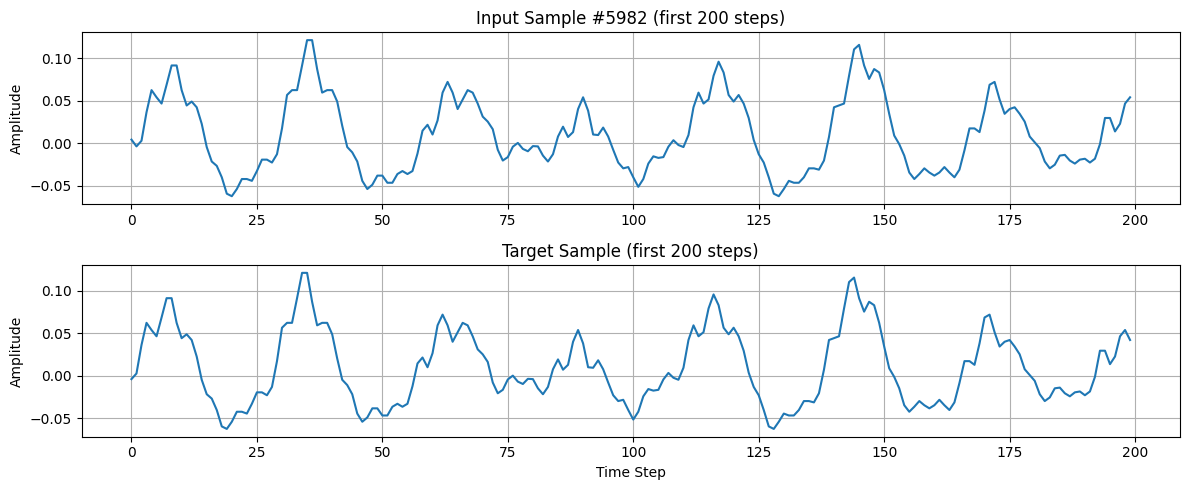

Visualized sample 5982 with variance 0.0013


In [115]:
# Visualize a non-silent sample from the dataset

def visualize_dataset_sample(
    dataset_file,
    item_length=1000,
    target_length=100,
    classes=None,
    train=True,
    max_tries=32,
):
    """Plot the first 200 steps of a non-silent dataset window."""
    dataset = WavenetDataset(
        dataset_file=dataset_file,
        item_length=item_length,
        target_length=target_length,
        classes=classes if classes is not None else 256,
        train=train,
    )
    classes = dataset.classes

    chosen = None
    for _ in range(max_tries):
        sample_idx = np.random.randint(len(dataset))
        one_hot, target = dataset[sample_idx]
        input_ints = torch.argmax(one_hot, dim=1).cpu()
        if torch.var(input_ints.float()) > 0:
            chosen = (sample_idx, input_ints, target.cpu())
            break

    if chosen is None:
        print("No non-silent segments were found. Increase max_tries or shuffle the dataset.")
        return

    sample_idx, input_ints, target_ints = chosen
    input_audio = inv_mulaw_quantize(input_ints.numpy(), quantization_channels=classes)
    target_audio = inv_mulaw_quantize(target_ints.numpy(), quantization_channels=classes)

    plt.figure(figsize=(12, 5))
    plt.subplot(2, 1, 1)
    plt.plot(input_audio[:200])
    plt.title(f'Input Sample #{sample_idx} (first 200 steps)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(target_audio[:200])
    plt.title('Target Sample (first 200 steps)')
    plt.xlabel('Time Step')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Visualized sample {sample_idx} with variance {float(np.var(input_audio)):.4f}")

# Example usage (provide the correct dataset path before running):
visualize_dataset_sample(
    dataset_file='audio_dataset.npz',
    item_length=1000,
    target_length=100,
    classes=128,
    train=True,
)

### Optimizer and Loss Function

5 Points

In [116]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# Optimizer: Adam optimizer with learning rate
learning_rate = 1e-3
optimizer = Adam(model.parameters(), lr=learning_rate)

# Loss function: Cross-entropy for categorical prediction
# Input: logits [batch_size, seq_len, n_category]
# Target: integers [batch_size, seq_len] in range [0, n_category-1]
criterion = CrossEntropyLoss()

print(f"Optimizer: Adam with lr={learning_rate}")
print(f"Loss function: CrossEntropyLoss")

Optimizer: Adam with lr=0.001
Loss function: CrossEntropyLoss


## Training

10 Points

In [ ]:
# Training loop
num_epochs = 10
batch_size = 4
grad_clip = 1.0

# Load dataset (adjust paths as needed)
dataset = WavenetDataset(dataset_file='audio_dataset.npz',
                         item_length=1000,
                         target_length=100,
                         classes=n_category,
                         train=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    # Uncomment when dataset is loaded:
    for batch_idx, (one_hot, target) in enumerate(dataloader):
    #     # Move to device
        one_hot = one_hot.to(device)
        target = target.to(device)
    #
    #     # Forward pass
    #     # Convert one-hot to integer indices for model input
        input_ints = torch.argmax(one_hot, dim=2).long()  # [batch_size, seq_len]
        logits = model(input_ints)  # [batch_size, seq_len, n_category]
    #
    #     # Reshape for loss calculation
        logits_flat = logits.reshape(-1, n_category)  # [batch_size * seq_len, n_category]
        target_flat = target.reshape(-1)  # [batch_size * seq_len]
    #
    #     # Calculate loss
        loss = criterion(logits_flat, target_flat)
    #
    #     # Backward pass
        optimizer.zero_grad()
        loss.backward()
    #
    #     # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    #
        optimizer.step()
    #
        epoch_loss += loss.item()
        num_batches += 1
    #
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')

    avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
    train_losses.append(avg_loss)
    print(f'Epoch {epoch} completed. Average Loss: {avg_loss:.4f}')

# print("Training loop ready. Uncomment and provide dataset to start training.")

one hot input
Epoch 0, Batch 0, Loss: 5.5466
Epoch 0, Batch 10, Loss: 5.2895
Epoch 0, Batch 20, Loss: 5.3762
Epoch 0, Batch 30, Loss: 5.1001
Epoch 0, Batch 40, Loss: 5.1262
Epoch 0, Batch 50, Loss: 5.0539
Epoch 0, Batch 60, Loss: 5.2806
Epoch 0, Batch 70, Loss: 5.0921
Epoch 0, Batch 80, Loss: 5.0501
Epoch 0, Batch 90, Loss: 5.0088
Epoch 0, Batch 100, Loss: 5.0282
Epoch 0, Batch 110, Loss: 4.8250
Epoch 0, Batch 120, Loss: 4.7900
Epoch 0, Batch 130, Loss: 4.4850
Epoch 0, Batch 140, Loss: 4.3919
Epoch 0, Batch 150, Loss: 4.1213
Epoch 0, Batch 160, Loss: 4.3915
Epoch 0, Batch 170, Loss: 3.8421
Epoch 0, Batch 180, Loss: 3.8778
Epoch 0, Batch 190, Loss: 3.8301
Epoch 0, Batch 200, Loss: 3.9186
Epoch 0, Batch 210, Loss: 4.0432
Epoch 0, Batch 220, Loss: 3.6501
Epoch 0, Batch 230, Loss: 3.6195
Epoch 0, Batch 240, Loss: 3.5641
Epoch 0, Batch 250, Loss: 3.5448
Epoch 0, Batch 260, Loss: 3.6314
Epoch 0, Batch 270, Loss: 3.6535
Epoch 0, Batch 280, Loss: 3.8385
Epoch 0, Batch 290, Loss: 3.6629
Epoch 0

## Plot losses

5 Points

In [ ]:
def plot_losses(trainLoss, Epochs):
    """
    Plot training losses over epochs.

    Args:
        trainLoss: List of training losses (one per epoch)
        Epochs: List or range of epoch numbers
    """
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, trainLoss, 'b-', label='Training Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training Loss over Epochs', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Final training loss: {trainLoss[-1]:.4f}")

## Save the model

5 Points


In [ ]:
# Save the model
save_path = 'wavenet_model.pth'

# Save model state dict
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'dilation_depth': dilation_depth,
    'n_blocks': n_blocks,
    'n_dilation_channels': n_dilation_channels,
    'n_residual_channels': n_residual_channels,
    'n_skip_channels': n_skip_channels,
    'n_category': n_category,
    'kernel_size': kernel_size,
}, save_path)

print(f"Model saved to {save_path}")

# To load the model later:
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Generate Audio using trained model

5 Points

In [ ]:
# Generate audio using trained model
model.eval()

# Start with a seed sequence (random or from dataset)
seed_length = 100
seed = torch.randint(0, n_category, (1, seed_length)).to(device)

# Or load a seed from dataset:
dataset = WavenetDataset(dataset_file='audio_dataset.npz',
                         item_length=100,
                         target_length=10,
                         classes=n_category,
                         train=False)
one_hot, _ = dataset[0]
seed = torch.argmax(one_hot, dim=1).unsqueeze(0).to(device)

# Generate samples
num_samples_to_generate = 1000
generated_samples = model.generate(seed, num_samples=num_samples_to_generate)

# Convert quantized samples back to audio
generated_array = np.array(generated_samples, dtype=np.int32)
#
# # Inverse mu-law quantization
mu = n_category - 1
audio_samples = inv_mulaw_quantize(generated_array, quantization_channels=n_category, device=device)
#
# # Convert to numpy if needed
if isinstance(audio_samples, torch.Tensor):
    audio_samples = audio_samples.cpu().numpy()
#
# # Save as audio file
output_path = 'generated_audio.wav'
import soundfile as sf
sf.write(output_path, audio_samples, 16000)  # 16kHz sampling rate
#
# # Or play directly in notebook
# from IPython.display import Audio
Audio(audio_samples, rate=16000)

# print("Audio generation code ready. Uncomment and provide seed to generate audio.")
# print("Make sure model is trained before generating!")

# Question 2: Pixel CNN / Pixel RNN (Optional)

In this question, we explore **deep autoregressive models** for image generation, focusing on PixelCNN and PixelRNN.  

Natural images are high-dimensional and exhibit strong spatial correlations between neighboring pixels. The **PixelRNN** aims to model the **full joint distribution** of pixel intensities, enabling exact likelihood computation and realistic image generation.  

Unlike VAEs or GANs, which rely on latent variables or adversarial training, PixelRNN treats the **image as a sequence of pixels** and directly models:  

$$
p(\mathbf{x}) = \prod_{i=1}^{N} p(x_i \mid x_1, x_2, \ldots, x_{i-1})
$$

Here, each pixel \(x_i\) is conditioned on all previously generated pixels, following a fixed **raster-scan order** (top-left → bottom-right). This transforms image modeling into a **sequence modeling task**, allowing recurrent neural networks (RNNs) to capture long-range spatial dependencies.  

---

### Core Idea

PixelRNN introduces **two-dimensional LSTM architectures** to preserve autoregressive dependencies in images:

- **Row LSTM:** Processes the image row by row (left-to-right), with recurrent connections across both rows and columns.  
- **Diagonal Bi-LSTM:** Processes pixels along diagonals, increasing the receptive field to include all previously generated pixels.  

To maintain causality across color channels, each pixel’s RGB values are generated sequentially (R → G → B).  

![PixelRNN Architecture](https://github.com/ParsaGhezelbash/Deep-Generative-Models/blob/main/HW/HW%201/image.png?raw=1)

---

### Architectural Components

1. **Masked Convolutions**  
   Convolutional filters are masked (type A or B) to prevent access to future pixels or channels during training.  

2. **Residual Connections**  
   Stacked recurrent layers use residual links to facilitate gradient flow in deep networks.  

3. **Discrete Softmax Output**  
   Each pixel channel is modeled as a categorical distribution over 256 intensity values, allowing exact log-likelihood computation.  

4. **Loss Function**  
   The training objective is the **negative log-likelihood** of the true pixels under the predicted distributions:

$$
\mathcal{L} = -\sum_i \log p(x_i \mid x_{<i})
$$

---

### Sampling and Generation

Image generation in PixelRNN is **fully autoregressive**:

1. Start at the top-left pixel.  
2. Sequentially sample each pixel from its predicted conditional distribution.  
3. Repeat until the entire image is generated.  

This method produces coherent, high-quality images but is computationally intensive, as each pixel depends on all previously generated pixels.  

---

**Reference:** [PixelRNN Paper (2016)](https://arxiv.org/abs/1601.06759)


## load Cifar10

5 Points

In [ ]:
import os
import math
import struct
from typing import List, Tuple
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

# CIFAR-10 constants
IMAGE_SIZE = 24  # CIFAR-10 images are 32x32, but we crop to 24x24
NUM_CLASSES = 10  # CIFAR-10 has 10 classes
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000  # CIFAR-10 training set has 50,000 images
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000  # CIFAR-10 test set has 10,000 images


def _read_cifar10_binary_file(path: str) -> List[Tuple[int, np.ndarray]]:
    """
    Reads a single CIFAR-10 binary file and returns a list of (label, image_array)
    where image_array is HxWxC uint8 (32x32x3).
    CIFAR-10 binary format: 1 byte label followed by 3072 bytes image (R(1024), G(1024), B(1024))
    """
    records = []
    record_size = 1 + 32 * 32 * 3
    with open(path, 'rb') as f:
        while True:
            bytes_read = f.read(record_size)
            if not bytes_read:
                break
            if len(bytes_read) != record_size:
                raise ValueError(f"Unexpected record size in {path}: {len(bytes_read)} bytes")
            # first byte is label
            label = bytes_read[0]
            img_flat = np.frombuffer(bytes_read[1:], dtype=np.uint8)
            # image is stored as [R..1024, G..1024, B..1024] each row-major for 32x32
            # reshape to (3, 32, 32) then transpose to (32, 32, 3)
            depth_major = img_flat.reshape((3, 32, 32))
            img = np.transpose(depth_major, (1, 2, 0))  # H, W, C
            records.append((int(label), img))
    return records

class CIFAR10BinaryDataset(Dataset):
    """
    Dataset that reads the CIFAR-10 binary files into memory (list of (label, image)).
    Applies transforms (train/eval) provided in init.
    """
    def __init__(self, data_dir: str, files: List[str], transform=None):
        """
        data_dir: directory containing the CIFAR-10 binary files.
        files: list of filenames (basename) to read from data_dir.
        transform: torchvision transform to apply to PIL image (or custom transform).
        """
        self.data_dir = data_dir
        self.files = files
        self.transform = transform

        # Load all records into memory (50k images is fine)
        self.records: List[Tuple[int, np.ndarray]] = []
        for fname in files:
            path = os.path.join(data_dir, fname)
            if not os.path.exists(path):
                raise ValueError(f"Failed to find file: {path}")
            self.records.extend(_read_cifar10_binary_file(path))

        if len(self.records) == 0:
            raise ValueError("No records loaded from CIFAR files.")

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        label, img_np = self.records[idx]
        # Convert to PIL Image (expects HxW or HxWxC)
        img = Image.fromarray(img_np)  # mode='RGB'
        if self.transform:
            img = self.transform(img)
        # After transforms, we expect a torch.FloatTensor image of shape [C, H, W]
        # Return label as long tensor
        return img, torch.tensor(label, dtype=torch.long)


class PerImageStandardization:
    """
    Mimics TensorFlow's per_image_standardization:
      (x - mean) / max(stddev, 1.0/sqrt(N))
    Works on a torch tensor image with shape (C, H, W) and dtype=float32 in range [0,1] or raw values.
    We'll expect inputs are float tensors in range [0,1].
    """
    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
        # tensor: C x H x W
        if not torch.is_floating_point(tensor):
            tensor = tensor.float()
        mean = tensor.mean()
        std = tensor.std()
        # N = number of pixels * channels
        N = tensor.numel()
        std_min = 1.0 / math.sqrt(N)
        std_adj = max(std.item(), std_min)
        return (tensor - mean) / std_adj


def _train_transform():
    """
    Returns torchvision transform for training (distortions similar to TF code):
    - Random crop to IMAGE_SIZE x IMAGE_SIZE from 32x32 image
    - Random horizontal flip
    - Random brightness and contrast (approximate TF random_brightness/random_contrast)
    - Convert to tensor (0..1)
    - Per-image standardization
    """
    # ColorJitter's brightness and contrast ranges take a factor. TF used:
    # random_brightness with max_delta=63 (on [0,255]) => approx +/- 0.25 in normalized 0..1
    # random_contrast lower=0.2 upper=1.8 => matches contrast jitter factor
    color_jitter = transforms.ColorJitter(brightness=0.25, contrast=(0.2, 1.8))
    return transforms.Compose([
        transforms.RandomCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        color_jitter,
        transforms.ToTensor(),  # gives C x H x W, float in [0,1]
        PerImageStandardization(),
    ])


def _eval_transform():
    """
    Returns transform for evaluation:
     - center crop / pad to IMAGE_SIZE x IMAGE_SIZE (TF used resize_image_with_crop_or_pad which crops center)
     - Convert to tensor and per-image standardize
    """
    # For 32->24 center crop:
    return transforms.Compose([
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        PerImageStandardization(),
    ])


def get_train_loader(data_dir: str, batch_size: int, num_workers: int = 16, shuffle: bool = True):
    """
    Returns a DataLoader for training (reads data_batch_1..5).
    """
    # CIFAR-10 training files
    train_files = [f'data_batch_{i}.bin' for i in range(1, 6)]

    # Create dataset with training transforms
    train_transform = _train_transform()
    dataset = CIFAR10BinaryDataset(data_dir, train_files, transform=train_transform)

    # Create DataLoader
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    return loader


def get_eval_loader(data_dir: str, batch_size: int, num_workers: int = 8, eval_data: bool = True):
    """
    Returns a DataLoader for evaluation.
    If eval_data==False it reads training batches (data_batch_1..5) else test_batch.bin
    """
    if eval_data:
        # Use test set
        eval_files = ['test_batch.bin']
    else:
        # Use training set for evaluation
        eval_files = [f'data_batch_{i}.bin' for i in range(1, 6)]

    # Create dataset with evaluation transforms
    eval_transform = _eval_transform()
    dataset = CIFAR10BinaryDataset(data_dir, eval_files, transform=eval_transform)

    # Create DataLoader (no shuffling for evaluation)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    return loader


## Diagonal LSTM and Masked Convolution

20 Points

In [ ]:
import logging
from typing import Optional, Tuple
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

logging.basicConfig(format="[%(asctime)s] %(message)s", datefmt="%m-%d %H:%M:%S")
logger = logging.getLogger(__name__)

DEFAULT_DATA_FORMAT = "NHWC"

def _is_nchw(x: torch.Tensor) -> bool:
    return x.dim() == 4 and x.shape[1] <= 4 and x.shape[2] > 4  # heuristic; not perfect

def ensure_nhwc(x: torch.Tensor) -> torch.Tensor:
    """Return tensor in NHWC layout (B,H,W,C)."""
    if x.dim() != 4:
        raise ValueError("Expect 4D tensor")
    # If likely NCHW (N,C,H,W) convert to NHWC
    if x.shape[1] <= 4 and x.shape[2] > 4:
        return x.permute(0, 2, 3, 1).contiguous()
    return x

def ensure_nchw(x: torch.Tensor) -> torch.Tensor:
    """Return tensor in NCHW layout (B,C,H,W)."""
    if x.dim() != 4:
        raise ValueError("Expect 4D tensor")
    # If likely NHWC convert to NCHW
    if x.shape[3] <= 4 and x.shape[1] > 4:
        return x.permute(0, 3, 1, 2).contiguous()
    if x.shape[1] <= 4 and x.shape[2] > 4:
        # ambiguous, assume NCHW already
        return x
    # assume NHWC (B,H,W,C)
    if x.shape[3] <= 4:
        return x.permute(0, 3, 1, 2).contiguous()
    return x

def get_shape(inputs: torch.Tensor):
    """Return python list-style shape similar to TF's .as_list()."""
    return list(inputs.size())

# ---------------------------
# skew / unskew (supports NHWC and NCHW; works on NHWC primarily)
# ---------------------------
def skew(inputs: torch.Tensor, scope: str = "skew") -> torch.Tensor:
    """
    The skew function performs a transformation on a 4D tensor,
    either in NHWC format (Batch, Height, Width, Channels) or NCHW format (Batch, Channels, Height, Width).
    The goal of skewing is to shift the data from its original height-wise structure into a diagonal format.
    Specifically, the function combines the height and width dimensions in a way that the resulting tensor has a width of W + H - 1,
    where W is the width of the input tensor and H is the height.
    Accepts NHWC ([B,H,W,C]) or NCHW ([B,C,H,W]) tensors.
    Returns NHWC tensor with new width = W + H - 1
    """
    # Check if input is NCHW and convert to NHWC
    was_nchw = _is_nchw(inputs)
    if was_nchw:
        inputs = ensure_nhwc(inputs)

    B, H, W, C = inputs.shape
    new_width = W + H - 1

    # Create output tensor with new width
    outputs = torch.zeros(B, H, new_width, C, dtype=inputs.dtype, device=inputs.device)

    # Skew operation: shift each row by its row index
    for h in range(H):
        outputs[:, h, h:h+W, :] = inputs[:, h, :, :]

    logger.debug(f"[skew] {scope} : {inputs.shape} -> {outputs.shape}")

    # if input was NCHW convert outputs back to NCHW style? The code returns NHWC.
    if was_nchw:
        # convert to NCHW before returning to be consistent with conv2d upstream expectations
        return outputs.permute(0, 3, 1, 2).contiguous()  # [B, C, H, new_width]
    return outputs  # NHWC

def unskew(inputs: torch.Tensor, width: Optional[int] = None, scope: str = "unskew") -> torch.Tensor:
    """
    The unskew function performs the reverse of the skew operation.
    It takes a skewed tensor and "un-skews" it back to its original shape.
    If NCHW is provided, it will be converted to NHWC internally and returns NHWC.
    """
    # Check if input is NCHW and convert to NHWC
    was_nchw = _is_nchw(inputs)
    if was_nchw:
        inputs = ensure_nhwc(inputs)

    B, H, skewed_width, C = inputs.shape

    # If width not provided, infer from skewed width: W = skewed_width - H + 1
    if width is None:
        width = skewed_width - H + 1

    # Create output tensor with original width
    outputs = torch.zeros(B, H, width, C, dtype=inputs.dtype, device=inputs.device)

    # Unskew operation: extract each row starting from its row index
    for h in range(H):
        outputs[:, h, :, :] = inputs[:, h, h:h+width, :]

    if was_nchw:
        return outputs.permute(0, 3, 1, 2).contiguous()
    logger.debug(f"[unskew] {scope} : -> {outputs.shape}")
    return outputs

# ---------------------------
# conv2d with optional mask (mask type None/'A'/'B')
# ---------------------------
class MaskedConv2d(nn.Module):
    """
    A conv2d that mimics TF behavior with variable creation and masking.
    The module expects inputs either in NHWC or NCHW; internally we run conv in NCHW.
    weights_shape = [kernel_h, kernel_w, in_channels, out_channels] (TF style).
    """
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: Tuple[int, int],
                 mask_type: Optional[str] = None,
                 stride: Tuple[int, int] = (1, 1),
                 padding: str = "SAME",
                 bias: bool = True,
                 weights_initializer=None,
                 name: str = "conv2d"):
        super().__init__()
        self.kernel_h, self.kernel_w = kernel_size
        self.mask_type = mask_type.lower() if mask_type is not None else None
        self.stride = stride
        self.padding = padding
        self.name = name

        # Create weight parameter in PyTorch conv format: [out_channels, in_channels, kh, kw]
        self.weight = nn.Parameter(torch.empty(out_channels, in_channels, self.kernel_h, self.kernel_w))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.register_parameter('bias', None)

        # Initialize weights (Xavier uniform by default)
        nn.init.xavier_uniform_(self.weight)

        # Precompute mask if needed (create in TF ordering then transpose to PyTorch ordering)
        if self.mask_type is not None:
            mask = np.ones((self.kernel_h, self.kernel_w, in_channels, out_channels), dtype=np.float32)
            center_h = self.kernel_h // 2
            center_w = self.kernel_w // 2
            mask[center_h, center_w + 1:, :, :] = 0.
            mask[center_h + 1:, :, :, :] = 0.
            if self.mask_type == 'a':
                mask[center_h, center_w, :, :] = 0.
            # convert mask to shape [out, in, kh, kw] for direct multiplication with self.weight
            mask = mask.transpose(3, 2, 0, 1).copy()
            self.register_buffer('mask', torch.tensor(mask))
        else:
            self.mask = None

    def forward(self, inputs: torch.Tensor):
        # Accept NHWC or NCHW. Convert to NCHW for conv
        is_nchw = _is_nchw(inputs)
        if not is_nchw:
            # Convert NHWC to NCHW
            x = inputs.permute(0, 3, 1, 2).contiguous()
        else:
            x = inputs

        # Apply mask to weights if needed
        if self.mask is not None:
            weight = self.weight * self.mask
        else:
            weight = self.weight

        # Calculate padding for "SAME" padding
        if self.padding == "SAME":
            pad_h = (self.kernel_h - 1) // 2
            pad_w = (self.kernel_w - 1) // 2
            padding = (pad_w, pad_w, pad_h, pad_h)  # (left, right, top, bottom)
            x = F.pad(x, padding, mode='constant', value=0)
            padding = (0, 0)  # PyTorch conv2d uses (pad_h, pad_w)
        else:
            padding = 0

        # Perform convolution
        out = F.conv2d(x, weight, self.bias, stride=self.stride, padding=padding)

        # return in same layout as input
        if not is_nchw:
            out = out.permute(0, 2, 3, 1).contiguous()
        logger.debug(f"[conv2d_{self.mask_type}] {self.name} : {inputs.shape} -> {out.shape}")
        return out

# conv1d implemented via conv2d with kernel_w = 1
class MaskedConv1d(MaskedConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=(1,1), padding="SAME", mask_type=None, bias=True, name="conv1d"):
        # kernel_size is int (height)
        super().__init__(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=(kernel_size, 1),
                         mask_type=mask_type,
                         stride=stride,
                         padding=padding,
                         bias=bias,
                         name=name)

# ---------------------------
# Diagonal LSTM Cell
# ---------------------------
class DiagonalLSTMCell(nn.Module):
    """
    Diagonal LSTM Cell equivalent converted from TF.
    - hidden_dims: number of hidden channels per spatial row
    - height: number of rows
    - channel: input channels (for conv1d s_to_s)
    """
    def __init__(self, hidden_dims: int, height: int, channel: int):
        super().__init__()
        self._hidden_dims = hidden_dims
        self._height = height
        self._channel = channel
        self._num_units = hidden_dims * height
        self._state_size = self._num_units * 2
        self._output_size = self._num_units

        # conv to compute s_to_s (2x1 conv as in TF conv1d)
        # We'll implement as a Conv2d with kernel (2,1) operating on [B, hidden_dims, height, 1]
        # But conv1d in TF used input channels = hidden_dims; output = 4*hidden_dims
        # Use groups=1
        self.s_to_s_conv = MaskedConv1d(in_channels=self._hidden_dims, out_channels=4*self._hidden_dims, kernel_size=2, padding="SAME", name='s_to_s')

    def forward(self, i_to_s: torch.Tensor, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        i_to_s: [B, 4 * height * hidden_dims]
        state: [B, 2 * num_units] where num_units = height * hidden_dims
        returns: h (B, height*hidden_dims), new_state (B, 2*num_units)
        """
        B = i_to_s.size(0)
        num_units = self._num_units

        # Split state into c (cell state) and h (hidden state)
        c_prev = state[:, :num_units]  # [B, num_units]
        h_prev = state[:, num_units:]  # [B, num_units]

        # Reshape h_prev to [B, hidden_dims, height, 1] for conv1d
        h_prev_reshaped = h_prev.view(B, self._hidden_dims, self._height, 1)

        # Compute s_to_s using conv1d (state to state)
        s_to_s = self.s_to_s_conv(h_prev_reshaped)  # [B, 4*hidden_dims, height, 1]
        s_to_s = s_to_s.squeeze(-1)  # [B, 4*hidden_dims, height]
        s_to_s = s_to_s.view(B, 4 * num_units)  # [B, 4 * height * hidden_dims]

        # Combine input-to-state and state-to-state
        gates = i_to_s + s_to_s  # [B, 4 * num_units]

        # Split gates into i, f, o, g
        i, f, o, g = torch.chunk(gates, 4, dim=1)  # Each: [B, num_units]

        # Apply activations
        i = torch.sigmoid(i)  # input gate
        f = torch.sigmoid(f)  # forget gate
        o = torch.sigmoid(o)  # output gate
        g = torch.tanh(g)     # candidate values

        # Update cell state and hidden state
        c_new = f * c_prev + i * g  # [B, num_units]
        h_new = o * torch.tanh(c_new)  # [B, num_units]

        # Concatenate new state
        new_state = torch.cat([c_new, h_new], dim=1)  # [B, 2*num_units]

        return h_new, new_state

# ---------------------------
# diagonal_lstm (sequence loop)
# ---------------------------
def diagonal_lstm(inputs: torch.Tensor, conf, scope: str = 'diagonal_lstm') -> torch.Tensor:
    """
    inputs: NHWC or NCHW. The function follows TF flow:
      - skew inputs -> conv2d 1x1 to produce input_to_state (skewed), transpose to [B, W, H, 4*hidden_dims]
      - reshape to rnn_inputs [B, W, H*4*hidden_dims] and iterate over width dimension
    conf must provide: hidden_dims (int), use_dynamic_rnn (bool optional)
    Returns: outputs in NHWC shape [B, H, W, hidden_dims]
    """
    # Check if input is NCHW and convert to NHWC
    was_nchw = _is_nchw(inputs)
    if was_nchw:
        inputs = ensure_nhwc(inputs)

    B, H, W, C = inputs.shape
    hidden_dims = conf.hidden_dims

    # Skew the inputs
    skewed = skew(inputs, scope=f"{scope}/skew")  # [B, H, W+H-1, C]
    _, _, skewed_width, _ = skewed.shape

    # 1x1 conv to produce input_to_state (4*hidden_dims channels)
    # Create a 1x1 conv layer for input_to_state
    i_to_s_conv = nn.Conv2d(C, 4 * hidden_dims, kernel_size=1).to(inputs.device)
    i_to_s_skewed = i_to_s_conv(skewed.permute(0, 3, 1, 2))  # [B, 4*hidden_dims, H, skewed_width]
    i_to_s_skewed = i_to_s_skewed.permute(0, 2, 3, 1)  # [B, H, skewed_width, 4*hidden_dims]

    # Transpose to [B, skewed_width, H, 4*hidden_dims]
    i_to_s_transposed = i_to_s_skewed.permute(0, 2, 1, 3)  # [B, skewed_width, H, 4*hidden_dims]

    # Reshape to [B, skewed_width, H*4*hidden_dims]
    rnn_inputs = i_to_s_transposed.reshape(B, skewed_width, H * 4 * hidden_dims)

    # Create LSTM cell
    lstm_cell = DiagonalLSTMCell(hidden_dims, H, C).to(inputs.device)

    # Initialize state
    num_units = hidden_dims * H
    state = torch.zeros(B, 2 * num_units, device=inputs.device)

    # Process sequence over width dimension
    outputs_list = []
    for w in range(skewed_width):
        i_to_s_w = rnn_inputs[:, w, :]  # [B, H*4*hidden_dims]
        h, state = lstm_cell(i_to_s_w, state)
        outputs_list.append(h)

    # Stack outputs: [B, skewed_width, num_units]
    outputs_skewed = torch.stack(outputs_list, dim=1)

    # Reshape to [B, skewed_width, H, hidden_dims]
    outputs_skewed = outputs_skewed.view(B, skewed_width, H, hidden_dims)

    # Transpose back to [B, H, skewed_width, hidden_dims]
    outputs_skewed = outputs_skewed.permute(0, 2, 1, 3)

    # Unskew to get original width
    outputs = unskew(outputs_skewed, width=W, scope=f"{scope}/unskew")  # [B, H, W, hidden_dims]

    if was_nchw:
        # convert back to NCHW to be consistent with upstream expectations
        return outputs.permute(0, 3, 1, 2).contiguous()
    return outputs

# ---------------------------
# diagonal_bilstm
# ---------------------------
def diagonal_bilstm(inputs: torch.Tensor, conf, scope: str = 'diagonal_bilstm') -> torch.Tensor:
    """
    Compose forward diagonal_lstm and backward diagonal_lstm then sum appropriately (as TF).
    If conf.use_residual is True, apply 1x1 conv residuals and add to inputs.
    Returns: sum of forward and backward outputs with backward last column zeroed and shifted similar to TF.
    """
    # Check if input is NCHW and convert to NHWC
    was_nchw = _is_nchw(inputs)
    if was_nchw:
        inputs = ensure_nhwc(inputs)

    B, H, W, C = inputs.shape

    # Forward pass
    out_fw = diagonal_lstm(inputs, conf, scope=f"{scope}/fw")

    # Backward pass: flip width dimension
    inputs_bw = torch.flip(inputs, dims=[2])  # Flip along width
    out_bw = diagonal_lstm(inputs_bw, conf, scope=f"{scope}/bw")
    out_bw = torch.flip(out_bw, dims=[2])  # Flip back

    # Zero out the last column of backward output (as in TF implementation)
    out_bw[:, :, -1, :] = 0

    # Apply residual connection if specified
    if hasattr(conf, 'use_residual') and conf.use_residual:
        # 1x1 conv for residual
        residual_conv = nn.Conv2d(C, conf.hidden_dims, kernel_size=1).to(inputs.device)
        residual = residual_conv(inputs.permute(0, 3, 1, 2))
        residual = residual.permute(0, 2, 3, 1)
        out_fw = out_fw + residual

    # Sum forward and backward
    output = out_fw + out_bw

    if was_nchw:
        output = output.permute(0, 3, 1, 2).contiguous()

    return output


In [ ]:
import os
import glob
import logging
from typing import Optional, Dict, Any, Iterable

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter

logger = logging.getLogger(__name__)
logging.basicConfig(format="[%(asctime)s] %(message)s", datefmt="%m-%d %H:%M:%S")


class Statistic:
    """
    the Statistic helper.

    Args:
        model: torch.nn.Module to save/load state_dict from.
        optimizer: optional torch.optim.Optimizer to save/load state.
        data_tag: str label used in TensorBoard scalar names .
        model_dir: directory where checkpoints and logs will be written.
        test_step: not used internally here but kept for API similarity (you can use it externally).
        max_to_keep: how many checkpoints to keep; older are deleted.
        device: device to load tensors to when loading checkpoints (default: cpu).
    """
    def __init__(
        self,
        model: nn.Module,
        optimizer: Optional[torch.optim.Optimizer],
        data_tag: str,
        model_dir: str,
        test_step: int,
        max_to_keep: int = 20,
        device: Optional[torch.device] = None,
    ):
        self.model = model
        self.optimizer = optimizer
        self.data_tag = data_tag
        self.model_dir = model_dir
        self.test_step = test_step
        self.max_to_keep = max_to_keep
        self.device = device if device is not None else torch.device("cpu")

        # internal counter t
        self.t = 0

        # tensorboard writer
        log_dir = os.path.join("logs", self.model_dir)
        os.makedirs(log_dir, exist_ok=True)
        self.writer = SummaryWriter(log_dir=log_dir)

        # Ensure model_dir exists for checkpoints
        os.makedirs(self.model_dir, exist_ok=True)

        # Optionally keep a list of saved checkpoints on disk (sorted)
        self._refresh_checkpoint_list()

        # call reset to initialize whatever you want (kept for API parity)
        self.reset()

        logger.info("Statistic initialized. logs -> %s, checkpoints -> %s", log_dir, self.model_dir)

    def reset(self):
        """
        Override or extend if you need to accumulate running statistics.
        """
        # user can extend this method if they want to keep rolling averages, etc.
        pass

    def _refresh_checkpoint_list(self):
        """
        Internal helper: update the cached list of checkpoint paths sorted by step (ascending).
        """
        pattern = os.path.join(self.model_dir, "checkpoint_*.pt")
        ckpts = glob.glob(pattern)
        # parse t from filename checkpoint_{t}.pt
        def _t_from_name(p):
            try:
                base = os.path.basename(p)
                t_str = base.replace("checkpoint_", "").replace(".pt", "")
                return int(t_str)
            except Exception:
                return -1
        ckpts_sorted = sorted(ckpts, key=_t_from_name)
        self._checkpoints = ckpts_sorted

    def _prune_checkpoints(self):
        """
        Keep only the last `max_to_keep` checkpoints, remove older ones.
        """
        self._refresh_checkpoint_list()
        if self.max_to_keep is None:
            return
        while len(self._checkpoints) > self.max_to_keep:
            old = self._checkpoints.pop(0)
            try:
                os.remove(old)
                logger.info("Removed old checkpoint: %s", old)
            except OSError:
                logger.warning("Failed to remove old checkpoint: %s", old)

    def on_step(self, train_l: float, test_l: float):
        """
        Called at end of a step (or epoch) to increment counter, write summaries, save checkpoints and reset accumulators.
        """
        # increment counter first
        self.t += 1

        # write summaries
        self.inject_summary({'train_l': train_l, 'test_l': test_l}, self.t)

        # save model
        self.save_model(self.t)

        # reset accumulators if any
        self.reset()

    def get_t(self) -> int:
        """Return current step counter."""
        return int(self.t)

    def inject_summary(self, tag_dict: Dict[str, float], t: Optional[int] = None):
        """
        Write scalar summaries to TensorBoard.
        tag_dict: mapping of tag->value, e.g. {'train_l': 0.5}
        t: step (if None uses current internal t)
        """
        step = self.t if t is None else int(t)
        for tag, value in tag_dict.items():
            full_tag = f"{self.data_tag}/{tag}"
            # ensure value is a python float
            try:
                val = float(value)
            except Exception:
                val = float(value.item()) if hasattr(value, "item") else float(value)
            self.writer.add_scalar(full_tag, val, step)
        # flush may be helpful to make summary available quickly
        self.writer.flush()

    def save_model(self, t: Optional[int] = None, extra_state: Optional[Dict[str, Any]] = None):
        """
        Save checkpoint for model (+ optimizer if supplied) and the internal counter 't'.
        extra_state: optional mapping of additional items to store (e.g., scheduler state).
        """
        step = self.t if t is None else int(t)
        ckpt_name = os.path.join(self.model_dir, f"checkpoint_{step}.pt")
        state = {
            't': step,
            'model_state': self.model.state_dict()
        }
        if self.optimizer is not None:
            state['optimizer_state'] = self.optimizer.state_dict()
        if extra_state:
            state['extra'] = extra_state

        # save atomically
        tmp_name = ckpt_name + ".tmp"
        torch.save(state, tmp_name)
        os.replace(tmp_name, ckpt_name)
        logger.info("Saved checkpoint: %s", ckpt_name)

        # refresh and prune
        self._refresh_checkpoint_list()
        self._prune_checkpoints()

    def load_model(self, checkpoint_path: Optional[str] = None, map_location: Optional[torch.device] = None) -> bool:
        """
        Load the latest checkpoint (if checkpoint_path is None) or load the provided checkpoint file.
        Returns True if load succeeded, False otherwise.
        map_location: device to map the checkpoint tensors onto (default: self.device)
        """

        map_location = map_location or self.device

        if checkpoint_path is None:
            # find latest checkpoint
            self._refresh_checkpoint_list()
            if not self._checkpoints:
                logger.info("No checkpoints found in %s", self.model_dir)
                return False
            checkpoint_path = self._checkpoints[-1]

        if not os.path.exists(checkpoint_path):
            logger.warning("Checkpoint path does not exist: %s", checkpoint_path)
            return False

        logger.info("Loading checkpoint: %s", checkpoint_path)
        ckpt = torch.load(checkpoint_path, map_location=map_location)

        # load model state
        if 'model_state' in ckpt:
            try:
                self.model.load_state_dict(ckpt['model_state'])
            except Exception as e:
                logger.exception("Failed to load model_state: %s", e)
                return False
        else:
            logger.warning("Checkpoint missing 'model_state' key")

        # load optimizer state if present and optimizer available
        if 'optimizer_state' in ckpt and self.optimizer is not None:
            try:
                self.optimizer.load_state_dict(ckpt['optimizer_state'])
            except Exception as e:
                logger.exception("Failed to load optimizer_state: %s", e)
                # continue, not fatal

        # restore t if present
        if 't' in ckpt:
            self.t = int(ckpt['t'])
        else:
            # try to infer from filename
            base = os.path.basename(checkpoint_path)
            try:
                self.t = int(base.replace("checkpoint_", "").replace(".pt", ""))
            except Exception:
                self.t = 0

        logger.info("Load SUCCESS: %s (t=%d)", checkpoint_path, int(self.t))
        return True


    def close(self):
        """Close writer etc."""
        try:
            self.writer.close()
        except Exception:
            pass


In [ ]:
import logging
logging.basicConfig(format="[%(asctime)s] %(message)s", datefmt="%m-%d %H:%M:%S")

import os
import sys
import pprint
import tarfile
import hashlib
import datetime
import numpy as np

from types import SimpleNamespace
from typing import Any, Dict, Iterable, Optional

# Python3 urllib
import urllib.request

from PIL import Image

pp = pprint.PrettyPrinter().pprint
logger = logging.getLogger(__name__)

# -------------------------
# Small helpers
# -------------------------
def mprint(matrix: Iterable[Iterable[float]], pivot: float = 0.5):
    """Pretty-print a binary-style matrix using '#' and ' ' like the original."""
    for array in matrix:
        print("".join("#" if i > pivot else " " for i in array))


def get_timestamp() -> str:
    """Return a filesystem-friendly timestamp string with local timezone info."""
    now = datetime.datetime.now().astimezone()
    return now.strftime('%Y_%m_%d_%H_%M_%S')


def binarize(images):
    """
    Binarize image(s) by sampling from Uniform(0,1) < pixel_value.
    Accepts a NumPy array or a PyTorch tensor. Returns same type as input (numpy or torch.FloatTensor).
    """
    try:
        import torch
        is_torch = torch.is_tensor(images)
    except Exception:
        is_torch = False

    if is_torch:
        # produce a tensor of same shape & device
        rand = torch.rand_like(images)
        return (rand < images).float()
    else:
        # assume numpy
        return (np.random.uniform(size=images.shape) < images).astype('float32')


# -------------------------
# Image saving
# -------------------------
def save_images(images, height: int, width: int, n_row: int, n_col: int,
                cmin: float = 0.0, cmax: float = 1.0, directory: str = "./", prefix: str = "sample"):
    """
    Save a grid of images to a single image file.
    - images: numpy array of shape (n_row*n_col, H, W) or (n_row*n_col, H, W, C)
              OR shaped (n_row, n_col, H, W) etc. This function will attempt to reshape sensibly.
    - height, width: single image H,W
    - n_row, n_col: grid layout
    """
    # convert torch -> numpy if needed
    try:
        import torch
        if torch.is_tensor(images):
            images = images.detach().cpu().numpy()
    except Exception:
        pass

    imgs = np.asarray(images)
    # handle shapes:
    # If flat list of images: (N, H, W) or (N, H, W, C)
    if imgs.ndim == 3:
        # grayscale stack
        N, H, W = imgs.shape
        C = 1
        imgs = imgs.reshape((N, H, W))
        imgs = imgs.reshape((n_row, n_col, H, W))
        imgs = imgs.transpose(1, 2, 0, 3).reshape((H * n_row, W * n_col))
        mode = 'L'
    elif imgs.ndim == 4:
        N, H, W, C = imgs.shape
        if C == 1:
            imgs = imgs.reshape((n_row, n_col, H, W))
            imgs = imgs.transpose(1, 2, 0, 3).reshape((H * n_row, W * n_col))
            mode = 'L'
        elif C == 3:
            # arrange into grid with channels last
            imgs = imgs.reshape((n_row, n_col, H, W, C))
            imgs = imgs.transpose(1, 2, 0, 3, 4).reshape((H * n_row, W * n_col, C))
            mode = 'RGB'
        else:
            # unsupported channel count: collapse or take first channel
            imgs = imgs[..., 0]
            imgs = imgs.reshape((n_row, n_col, H, W))
            imgs = imgs.transpose(1, 2, 0, 3).reshape((H * n_row, W * n_col))
            mode = 'L'
    else:
        raise ValueError("Unsupported image array shape: %s" % (imgs.shape,))

    # scale pixels from [cmin,cmax] to [0,255]
    if mode == 'L':
        norm = (imgs - cmin) / max((cmax - cmin), 1e-8)
        arr = np.clip(norm * 255.0, 0, 255).astype(np.uint8)
        pil_img = Image.fromarray(arr, mode='L')
    else:
        norm = (imgs - cmin) / max((cmax - cmin), 1e-8)
        arr = np.clip(norm * 255.0, 0, 255).astype(np.uint8)
        pil_img = Image.fromarray(arr, mode='RGB')

    filename = f'{prefix}_{get_timestamp()}.jpg'
    out_path = os.path.join(directory, filename)
    os.makedirs(directory, exist_ok=True)
    pil_img.save(out_path)
    logger.info("Saved image grid to %s", out_path)


# -------------------------
# Model / config helpers
# -------------------------
def get_model_dir(config, exceptions=None):
    """
    Robust replacement for TF-specific get_model_dir:
      - Accepts TF flags object (which stores flags under __flags) or argparse/Namespace/SimpleNamespace.
      - Builds a readable model dir name from config key/value pairs excluding `exceptions`.
      - If the generated name is too long, falls back to an md5 hash to keep path sane.
    """
    exceptions = set(exceptions or [])
    # Try TF-style flags first
    try:
        if hasattr(config, '__dict__') and '__flags' in config.__dict__:
            attrs = dict(config.__dict__['__flags'])
        else:
            # argparse.Namespace / SimpleNamespace / plain object
            attrs = dict(vars(config))
    except Exception:
        # as a last resort, try to use __dict__
        try:
            attrs = dict(config.__dict__)
        except Exception:
            attrs = {}

    # Filter out exceptions and None/empty values that are not informative
    items = []
    for k in sorted(attrs.keys()):
        if k in exceptions:
            continue
        if k.startswith('_'):
            continue
        v = attrs[k]
        if callable(v):
            vstr = v.__name__
        else:
            try:
                vstr = str(v)
            except Exception:
                vstr = repr(v)
        # shorten long values
        if len(vstr) > 40:
            vstr = hashlib.md5(vstr.encode('utf-8')).hexdigest()[:8]
        items.append(f"{k}={vstr}")

    if not items:
        name = "default"
    else:
        name = "_".join(items)

    # sanitize name (remove spaces, slashes)
    name = name.replace(" ", "").replace("/", "_").replace("\\", "_")

    # If too long, shorten using md5
    if len(name) > 180:
        name = hashlib.md5(name.encode("utf-8")).hexdigest()

    return os.path.join('checkpoints', name) + '/'


def preprocess_conf(conf):
    """
    Placeholder to keep API parity with your previous code.
    If you need to normalize or canonicalize flags/options, do it here.
    """
    # For argparse/Namespace we don't need to do anything by default.
    return conf


def check_and_create_dir(directory: str):
    """Create dir if not exists (logs)"""
    if not os.path.exists(directory):
        logger.info('Creating directory: %s' % directory)
        os.makedirs(directory)
    else:
        logger.info('Skip creating directory: %s' % directory)


def show_all_variables(model: Optional[Any] = None):
    """
    Print all trainable variables.
    If `model` is provided (torch.nn.Module), iterate its parameters.
    """
    try:
        import torch
        if model is None:
            logger.warning("No model passed to show_all_variables(model). Nothing to show.")
            return
        total_count = 0
        for idx, (name, param) in enumerate(model.named_parameters()):
            shape = tuple(param.shape)
            count = int(np.prod(shape))
            print("[%2d] %s %s = %s" % (idx, name, shape, count))
            total_count += count
        print("[Total] variable size: %s" % "{:,}".format(total_count))
    except Exception as e:
        logger.exception("show_all_variables failed: %s", e)

## Network
in this part we will impelement a neural network that can be configured to perform pixel-wise predictions, specifically for image generation tasks such as those in PixelCNN or PixelRNN models. This class supports both training and inference, and can generate outputs pixel-by-pixel in a raster scan order, leveraging various types of convolutions (standard and masked) and recurrent layers (e.g., LSTM).

25 Points

In [ ]:
import os
import math
import logging
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

logger = logging.getLogger(__name__)
logging.basicConfig(format="[%(asctime)s] %(message)s", datefmt="%m-%d %H:%M:%S")


class Network(nn.Module):
    """
    PyTorch Network class.
    """
    def __init__(self, conf, height: int, width: int, channel: int, device: Optional[torch.device] = None):
        super().__init__()
        logger.info("Building %s starts!" % conf.model)
        self.conf = conf
        self.data = conf.data
        self.height, self.width, self.channel = height, width, channel
        self.device = device if device is not None else (torch.device("cuda") if conf.use_gpu and torch.cuda.is_available() else torch.device("cpu"))

        # Data format decisions
        self.data_format = "NHWC" if conf.use_gpu else "NCHW"

        # Build layers - FIXED CHANNEL DIMENSIONS
        in_channels = channel

        # Calculate conv_out_channels based on residual connections
        if conf.use_residual and conf.model == "pixel_rnn":
            conv_out_channels = conf.hidden_dims * 2
        else:
            conv_out_channels = conf.hidden_dims

        # Input convolution
        self.conv_inputs = nn.Conv2d(in_channels, conv_out_channels, kernel_size=7, padding=3)

        # Build recurrent/conv layers
        self.recurrent_length = conf.recurrent_length
        self.out_recurrent_length = conf.out_recurrent_length

        if conf.model == "pixel_cnn":
            # For pixel_cnn, use masked convolutions with proper channel dimensions
            self.conv_blocks = nn.ModuleList()
            for idx in range(self.recurrent_length):
                in_ch = conv_out_channels if idx == 0 else conf.hidden_dims
                # Use regular conv2d for now - replace with masked conv if available
                self.conv_blocks.append(nn.Conv2d(in_ch, conf.hidden_dims, kernel_size=3, padding=1))
        else:
            # For pixel_rnn we will call diagonal_bilstm in forward()
            self.conv_blocks = None

        # Output recurrent layers (1x1 convs + ReLU)
        self.out_convs = nn.ModuleList()
        for idx in range(self.out_recurrent_length):
            in_ch = conf.hidden_dims if idx == 0 else conf.out_hidden_dims
            self.out_convs.append(nn.Conv2d(in_ch, conf.out_hidden_dims, kernel_size=1))

        # Final logits conv - FIXED: output should match input channels for binary prediction
        if channel == 1:
            # Single output logit per pixel
            in_ch = conf.out_hidden_dims if self.out_recurrent_length > 0 else conv_out_channels
            self.conv2d_out_logits = nn.Conv2d(in_ch, 1, kernel_size=1)
            self.loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
        else:
            # For RGB/categorical (not implemented in original)
            raise NotImplementedError("RGB branch not implemented (same as original).")

        # Optimizer (RMSProp) and grad clipping
        self.optimizer = optim.RMSprop(self.parameters(), lr=conf.learning_rate)
        self.grad_clip = conf.grad_clip

        # Move to device
        self.to(self.device)
        logger.info("Building %s finished!" % conf.model)

    def _to_nchw(self, x: torch.Tensor) -> torch.Tensor:
        """Convert incoming tensor to NCHW for internal conv ops."""
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
        x = x.to(self.device)
        if x.dim() != 4:
            raise ValueError("Input must be 4D tensor")
        if self.data_format == "NHWC":
            # [B,H,W,C] -> [B,C,H,W]
            x = x.permute(0, 3, 1, 2).contiguous()
        return x.float()

    def _to_output_layout(self, x: torch.Tensor) -> torch.Tensor:
        """Convert internal outputs (NCHW) back to requested external layout."""
        if self.data_format == "NHWC":
            return x.permute(0, 2, 3, 1).contiguous()
        return x

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        # Convert to NCHW for internal processing
        x = self._to_nchw(inputs)  # [B, C, H, W]

        # Input convolution
        x = self.conv_inputs(x)  # [B, conv_out_channels, H, W]
        x = F.relu(x)

        # Process through recurrent/conv layers
        if self.conf.model == "pixel_cnn":
            # PixelCNN: masked convolutions
            for conv_block in self.conv_blocks:
                residual = x
                x = F.relu(conv_block(x))
                # Add residual connection if channels match
                if x.shape[1] == residual.shape[1]:
                    x = x + residual
        elif self.conf.model == "pixel_rnn":
            # PixelRNN: diagonal bidirectional LSTM
            # Convert to NHWC for diagonal_bilstm
            x_nhwc = x.permute(0, 2, 3, 1).contiguous()  # [B, H, W, C]

            # Process through recurrent layers (diagonal_bilstm)
            for _ in range(self.recurrent_length):
                x_nhwc = diagonal_bilstm(x_nhwc, self.conf, scope='diagonal_bilstm')
                x_nhwc = F.relu(x_nhwc)

            # Convert back to NCHW
            x = x_nhwc.permute(0, 3, 1, 2).contiguous()  # [B, C, H, W]

        # Output recurrent layers (1x1 convs + ReLU)
        for out_conv in self.out_convs:
            x = F.relu(out_conv(x))

        # Final logits convolution
        logits = self.conv2d_out_logits(x)  # [B, 1, H, W] for binary

        # Return in external layout
        return self._to_output_layout(logits)

    def predict(self, images):
        """Predict probabilities for given images."""
        self.eval()
        with torch.no_grad():
            # Convert to tensor if needed
            if isinstance(images, np.ndarray):
                images = torch.from_numpy(images).float()

            # Move to device
            images = images.to(self.device)

            # Forward pass to get logits
            logits = self.forward(images)  # [B, H, W, 1] or [B, 1, H, W]

            # Convert to probabilities using sigmoid (for binary classification)
            probs = torch.sigmoid(logits)

            # Convert to numpy
            probs_t = probs.detach().cpu()

        return probs_t.numpy()

    def test(self, images, with_update: bool = False):
        """Compute loss for images, optionally update weights."""
        if with_update:
            self.train()
            self.optimizer.zero_grad()
        else:
            self.eval()

        # Convert to tensor if needed
        if isinstance(images, np.ndarray):
            images = torch.from_numpy(images).float()

        # Move to device
        images = images.to(self.device)

        # For binary images, targets are the same as inputs (predict next pixel)
        # In autoregressive models, we predict each pixel given previous ones
        # For simplicity, we use the image as both input and target
        # In practice, you'd shift the target by one pixel
        targets = images

        # Forward pass
        logits = self.forward(images)  # [B, H, W, 1] or [B, 1, H, W]

        # Ensure logits and targets have same shape
        if logits.dim() == 4:
            if self.data_format == "NHWC":
                # [B, H, W, 1] -> [B, 1, H, W] for loss
                logits = logits.permute(0, 3, 1, 2)
            # Now logits is [B, 1, H, W]
            if targets.dim() == 3:
                targets = targets.unsqueeze(1)  # [B, 1, H, W]
            elif targets.dim() == 4 and targets.shape[1] != 1:
                # If targets are [B, H, W], add channel dimension
                targets = targets.unsqueeze(1)

        # Compute loss
        loss_val = self.loss_fn(logits, targets)

        if with_update:
            loss_val.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.parameters(), self.grad_clip)
            self.optimizer.step()

        return float(loss_val.item())

    def generate(self, batch_size: int = 100):
        """Generate binary samples in raster order."""
        self.eval()
        H, W = self.height, self.width

        # Initialize image with zeros (or random values)
        samples = torch.zeros(batch_size, self.channel, H, W, device=self.device)

        with torch.no_grad():
            # Generate pixels in raster scan order (top-left to bottom-right)
            for h in range(H):
                for w in range(W):
                    # Get current partial image
                    current_image = samples.clone()

                    # Convert to appropriate format for forward pass
                    if self.data_format == "NHWC":
                        current_nhwc = current_image.permute(0, 2, 3, 1)  # [B, H, W, C]
                    else:
                        current_nhwc = current_image  # [B, C, H, W]

                    # Forward pass to get logits for current pixel
                    logits = self.forward(current_nhwc)  # [B, H, W, 1] or [B, 1, H, W]

                    # Extract logit for current pixel position
                    if self.data_format == "NHWC":
                        # logits is [B, H, W, 1]
                        pixel_logits = logits[:, h, w, :]  # [B, 1]
                    else:
                        # logits is [B, 1, H, W]
                        pixel_logits = logits[:, :, h, w]  # [B, 1]

                    # Convert to probability
                    pixel_probs = torch.sigmoid(pixel_logits)  # [B, 1]

                    # Sample binary value from Bernoulli distribution
                    pixel_values = torch.bernoulli(pixel_probs)  # [B, 1]

                    # Update the pixel in the sample
                    if self.data_format == "NHWC":
                        samples[:, :, h, w] = pixel_values.squeeze(-1)  # [B, C]
                    else:
                        samples[:, :, h, w] = pixel_values  # [B, C]

        # Convert to numpy if needed, or return as tensor
        # Return in format [B, H, W] or [B, C, H, W]
        if self.channel == 1:
            samples = samples.squeeze(1)  # [B, H, W]

        return samples.detach().cpu().numpy()

## Main

10 Points

In [ ]:
import os
import logging
import argparse
import math
from types import SimpleNamespace

import numpy as np
from tqdm import trange
from itertools import islice

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


# logging
logging.basicConfig(format="[%(asctime)s] %(message)s", datefmt="%m-%d %H:%M:%S")
logger = logging.getLogger()
# default level set later by args

def parse_args():
    parser = argparse.ArgumentParser()
    # network
    parser.add_argument("--model", type=str, default="pixel_cnn", help="name of model [pixel_rnn, pixel_cnn]")
    parser.add_argument("--batch_size", type=int, default=100, help="size of a batch")
    parser.add_argument("--hidden_dims", type=int, default=16, help="dimesion of hidden states of LSTM or Conv layers")
    parser.add_argument("--recurrent_length", type=int, default=7, help="the length of LSTM or Conv layers")
    parser.add_argument("--out_hidden_dims", type=int, default=32, help="dimesion of hidden states of output Conv layers")
    parser.add_argument("--out_recurrent_length", type=int, default=2, help="the length of output Conv layers")
    parser.add_argument("--use_residual", action="store_true", default=False, help="whether to use residual connections or not")

    # training
    parser.add_argument("--max_epoch", type=int, default=100000, help="# of step in an epoch")
    parser.add_argument("--test_step", type=int, default=100, help="# of step to test a model")
    parser.add_argument("--save_step", type=int, default=1000, help="# of step to save a model")
    parser.add_argument("--learning_rate", type=float, default=1e-3, help="learning rate")
    parser.add_argument("--grad_clip", type=float, default=1.0, help="value of gradient to be used for clipping")
    parser.add_argument("--use_gpu", action="store_true", default=True, help="whether to use gpu for training")

    # data
    parser.add_argument("--data", type=str, default="mnist", help="name of dataset [mnist, cifar]")
    parser.add_argument("--data_dir", type=str, default="data", help="name of data directory")
    parser.add_argument("--sample_dir", type=str, default="samples", help="name of sample directory")

    # debug / misc
    parser.add_argument("--is_train", action="store_true", default=True, help="training or testing")
    parser.add_argument("--display", action="store_true", default=False, help="whether to display the training results or not")
    parser.add_argument("--log_level", type=str, default="INFO", help="log level [DEBUG, INFO, WARNING, ERROR, CRITICAL]")
    parser.add_argument("--random_seed", type=int, default=123, help="random seed for python")

    return parser.parse_args([]) # Pass an empty list to parse_args

def main():
    args = parse_args()
    # convert argparse Namespace to a conf-like SimpleNamespace (so older code expecting attributes works)
    conf = SimpleNamespace(**vars(args))

    # logging level
    logger.setLevel(conf.log_level)

    # random seeds
    np.random.seed(conf.random_seed)
    torch.manual_seed(conf.random_seed)
    if conf.use_gpu and torch.cuda.is_available():
        torch.cuda.manual_seed_all(conf.random_seed)

    # Build model dir and preprocess config if helper exists
    model_dir = get_model_dir(conf,
                              ['data_dir', 'sample_dir', 'max_epoch', 'test_step', 'save_step',
                               'is_train', 'random_seed', 'log_level', 'display'])
    preprocess_conf(conf)

    DATA_DIR = os.path.join(conf.data_dir, conf.data)
    SAMPLE_DIR = os.path.join(conf.sample_dir, conf.data, model_dir)

    check_and_create_dir(DATA_DIR)
    check_and_create_dir(SAMPLE_DIR)

    device = torch.device("cuda" if (conf.use_gpu and torch.cuda.is_available()) else "cpu")
    logger.info("Using device: %s", device)

    # 0. prepare datasets
    if conf.data == "cifar":
        # Load CIFAR-10 datasets
        train_loader = get_train_loader(DATA_DIR, conf.batch_size, num_workers=4, shuffle=True)
        test_loader = get_eval_loader(DATA_DIR, conf.batch_size, num_workers=2, eval_data=True)

        # CIFAR-10 image dimensions
        height, width, channel = IMAGE_SIZE, IMAGE_SIZE, 3
    else:
        raise ValueError("Unknown dataset: %s" % conf.data)

    # 1. Build network
    network = Network(conf, height, width, channel, device=device)
    logger.info("Network created with %d parameters", sum(p.numel() for p in network.parameters()))

    try:
        stat = Statistic(network, network.optimizer, conf.data, model_dir, conf.test_step)
    except TypeError:
        # older Statistic signature variations: try with optimizer attr
        stat = Statistic(network, network.optimizer if hasattr(network, 'optimizer') else None, conf.data, model_dir, conf.test_step)

    # Try loading existing checkpoint
    stat.load_model()

    if conf.is_train:
        logger.info("Training starts!")
        initial_step = stat.get_t() if stat else 0
        iterator = trange(conf.max_epoch, ncols=70, initial=initial_step)

        for epoch in iterator:
            # 1. train
            network.train()
            train_loss = 0.0
            train_count = 0

            for batch_idx, (images, labels) in enumerate(train_loader):
                # Convert images to binary if needed (for binary image generation)
                # CIFAR-10 images are already normalized, but we might want to binarize
                # For now, we'll use the normalized images directly
                images = images.to(device)

                # Convert to appropriate format (NCHW)
                if network.data_format == "NHWC":
                    images = images.permute(0, 2, 3, 1)  # [B, C, H, W] -> [B, H, W, C]

                # Compute loss and update
                loss = network.test(images, with_update=True)
                train_loss += loss
                train_count += 1

                if batch_idx % 10 == 0:
                    logger.debug("Epoch %d, Batch %d, Loss: %.4f", epoch, batch_idx, loss)

            avg_train_loss = train_loss / train_count if train_count > 0 else 0.0

            # 2. test
            network.eval()
            test_loss = 0.0
            test_count = 0

            with torch.no_grad():
                for images, labels in islice(test_loader, 100):  # Limit test batches
                    images = images.to(device)

                    if network.data_format == "NHWC":
                        images = images.permute(0, 2, 3, 1)

                    loss = network.test(images, with_update=False)
                    test_loss += loss
                    test_count += 1

            avg_test_loss = test_loss / test_count if test_count > 0 else 0.0

            # Update statistics
            stat.on_step(avg_train_loss, avg_test_loss)

            # Update progress bar
            iterator.set_description(f"Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

            # 3. generate samples
            if epoch % conf.save_step == 0 or epoch == conf.max_epoch - 1:
                logger.info("Generating samples at epoch %d", epoch)
                network.eval()
                samples = network.generate(batch_size=16)  # Generate 16 samples

                # Save samples
                save_images(samples, height, width, n_row=4, n_col=4,
                           cmin=0.0, cmax=1.0, directory=SAMPLE_DIR,
                           prefix=f"epoch_{epoch}")

                logger.info("Samples saved to %s", SAMPLE_DIR)
    else:
        # Testing/inference mode
        logger.info("Running in test mode")
        network.eval()

        # Generate samples
        samples = network.generate(batch_size=64)
        save_images(samples, height, width, n_row=8, n_col=8,
                   cmin=0.0, cmax=1.0, directory=SAMPLE_DIR,
                   prefix="test_samples")

        logger.info("Test samples saved to %s", SAMPLE_DIR)


if __name__ == "__main__":
    main()